100


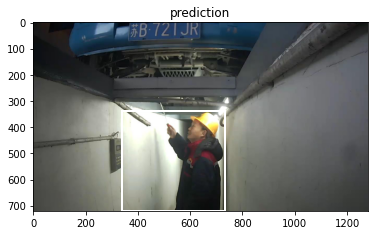

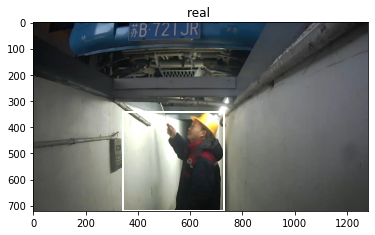

[506.793   338.0302  733.0633  718.50195] [509. 342. 729. 720.]
0.9584744931357179


In [2]:
from tkinter import TRUE
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms,datasets,models
import torch
from torch.utils.data import Dataset, DataLoader
#引入预训练模型
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os 
from torch.utils.data.dataset import random_split
from torch.utils.data import SubsetRandomSampler
import random
random.seed(1234)
#选择第几张照片
CHOICE = 12
#在 xml 中读取bbox
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    return [xmin,ymin,xmax,ymax]

#在xml 读取label 二分类，为person
def generate_person_label(obj):
    #person 返回1 不是返回0
    return obj.find('name').text =='person'

def generate_target(image_id,file):
    with open(file,'r',encoding='utf-8') as f :
        data = f.read()
        soup  = BeautifulSoup(data,'lxml-xml')
        objs = soup.find_all('object')
        nums_objs = len(objs)
        boxes = []
        labels = []
        for i in objs:
            boxes.append(generate_box(i))
            labels.append(generate_person_label(i))
        #make data
        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        labels = torch.as_tensor(labels,dtype=torch.int64)
        img_id = torch.tensor([image_id])
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = img_id
        return target
#因为不对等 所以要把图片名字和xml文件名字对应起来
# labels = [img[:-4]+'.xml' for img in imgs]
labels = list(sorted(os.listdir('D:\\ML_data_sql\\human_detect\\annotations\\')))
imgs = [label[:-4]+'.jpg' for label in labels]
#使用一部分数据（0.2倍）
#100张图片 随机一张进行测试
test_labels = random.sample(labels,100)
test_imgs = [label[:-4]+'.jpg' for label in test_labels]

#make dataset
class PersonDataset(object):
    def __init__(self,transforms,imgs,labels):
        self.transforms = transforms
        self.imgs = imgs
        self.labels = labels
        self.lens = len(imgs)
    
    def __getitem__(self,idx):
        #load images and masks
        img = Image.open('D:\\ML_data_sql\\human_detect\\JPEGImages\\'+self.imgs[idx])
        #label = generate_target(idx,'D:\\ML_data_sql\\human_detect\\annotations\\'+self.labels[idx])
        target = generate_target(idx,'D:\\ML_data_sql\\human_detect\\annotations\\'+self.labels[idx])
        #apply transforms
        if self.transforms is not None:
            img = self.transforms(img)
        return img,target
    
    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])   

test_dataset =PersonDataset(data_transform,test_imgs,test_labels)
#使用一部分数据
# test_dataset =SubsetRandomSampler(test_dataset[:int(len(test_dataset)*0.2)])
print(test_dataset.lens)
#因为dataset 有点大 爆显存 所以使用少量来训练
# def collate_fn(batch):
#     return tuple(zip(*batch))

# testdata_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,collate_fn=collate_fn)

#build the model
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
#load the model
model = get_model_instance_segmentation(2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load('D:\\Machine_Learning_note\\CV\\model_final.pth'))
model.eval()
model.to(device)
#test_dataset 有45个
input_img,labels = test_dataset[CHOICE]
input_img = input_img.unsqueeze(0)
pred = model(input_img.to(device))[0]
pred_box = pred['boxes'].detach().cpu().numpy()
real = labels['boxes'].detach().cpu().numpy()

def plot_image(img_tensor,pred,p_or_r):
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    xmin,ymin,xmax,ymax = pred[0][1],pred[0][1],pred[0][2],pred[0][3]
    #xmin, ymin, xmax, ymax = [427.7730, 534.9896, 638.9386, 720.0000]
    # Create a Rectangle patch
    rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='white',facecolor='none') 
    # Add the patch to the Axes
    ax.add_patch(rect)
    if p_or_r:
        plt.title('prediction')
    else:
        plt.title('real ')
    plt.show()
plot_image(input_img.squeeze(0),pred_box,True)
plot_image(input_img.squeeze(0),real,False)

#evaluate one picture by compute iou
def compute_iou(box1, box2, standard_coordinates=True):
    '''
    :param box1: [Xmin, Ymin, Xmax, Ymax] or [Xcenter, Ycenter, W, H]
    :param box2:
    :param standard_coordinates: True [Xmin, Ymin, Xmax, Ymax] Fasle [Xcenter, Ycenter, W, H]
    :return:
    '''
    # 传进来的是标准坐标
    if standard_coordinates is True:
        Xmin1, Ymin1, Xmax1, Ymax1 = box1
        Xmin2, Ymin2, Xmax2, Ymax2 = box2
    # 传进来的是中心坐标
    else:
        Xcenter1, Ycenter1, W1, H1 = box1
        Xcenter2, Ycenter2, W2, H2 = box2
        Xmin1, Ymin1 = int(Xcenter1 - W1 / 2), int(Ycenter1 - H1 / 2)
        Xmax1, Ymax1 = int(Xcenter1 + W1 / 2), int(Ycenter1 + H1 / 2)
        Xmin2, Ymin2 = int(Xcenter2 - W2 / 2), int(Ycenter2 - H2 / 2)
        Xmax2, Ymax2 = int(Xcenter2 + W2 / 2), int(Ycenter2 + H2 / 2)

    # 获得相交区域的左上角坐标和右下角坐标 min = max(min) max = min(max)
    inter_Xmin = max(Xmin1, Xmin2)
    inter_Ymin = max(Ymin1, Ymin2)
    inter_Xmax = min(Xmax1, Xmax2)
    inter_Ymax = min(Ymax1, Ymax2)

    # 以免不相交
    W = max(0, inter_Xmax - inter_Xmin)
    H = max(0, inter_Ymax - inter_Ymin)

    # 计算相交区域面积
    inter_area = W * H

    # 计算并集面积
    merge_area = (Xmax1 - Xmin1) * (Ymax1 - Ymin1) + (Xmax2 - Xmin2) * (Ymax2 - Ymin2)

    # 计算IOU
    IOU = inter_area / (merge_area - inter_area + 1e-6)

    return IOU

iou = compute_iou(pred_box[0], real[0])
print(pred_box[0], real[0])
print(iou)